# Quantum Circuit State Learning with JAX

In this notebook, we train a simple 2-qubit parameterized quantum circuit to match a target quantum state using PennyLane and JAX.

Basically, we are teaching the circuit to learn to produce a given quantum state.

We use optax for optimization.

In [1]:
import pennylane as qml
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt

We’ll use PennyLane’s default.qubit device with 2 qubits.

In [2]:
# Device
dev = qml.device("default.qubit", wires=2)

## Choose a Target State

We’ll use the Bell state:

$
\left| \Phi^+ \right\rangle = \frac{1}{\sqrt{2}} \left( \left| 00 \right\rangle + \left| 11 \right\rangle \right)
$

In [3]:
target_state = (1/jnp.sqrt(2)) * jnp.array([1.0, 0.0, 0.0, 1.0])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Define Parameterized Ansatz

We use two layers of single-qubit rotations and a CNOT entangling gate:

In [4]:
@qml.qnode(dev, interface="jax")  # This makes the parameters on the chosen device (jax).
def circuit(params):  # params is a (2,3) array: each qubit has 3 rotation angles.
    for i in range(2):
        qml.Rot(*params[i], wires=i)
    qml.CNOT(wires=[0,1])
    return qml.state()

## Define the loss function

We use the L2 distance between the circuit’s output state and the target state:

In [5]:
@jax.jit
def loss_fn(params, target_state):
    output_state = circuit(params)
    diff = output_state - target_state
    return jnp.vdot(diff, diff).real

With @jax.jit, JAX traces loss_fn:

- It records that `circuit(params)` is a pure function.
- It fuses all the classical math (like subtraction, vdot).
- It caches the call to circuit with the same computation graph.

AX will avoid re-tracing the QNode call for the same shape of parameters.

But it can’t fuse the internal gates since it treats the circuit as a black box.

## Set up the optimizer

We use optax.adam:

In [6]:
optimizer = optax.adam(0.1)

## Initialize parameters

We’ll start with all-zero parameters:

In [7]:
params = jnp.zeros((2,3))
opt_state = optimizer.init(params)

We could also try jax.random.uniform for random initialization.

## Training loop

We optimize the parameters to minimize the loss:

In [8]:
@jax.jit
def train_step(params, opt_state, target_state):
    loss, grads = jax.value_and_grad(loss_fn)(params, target_state)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

In [9]:
# Training loop using JAX
num_steps = 100
loss_history = []
for i in range(num_steps):
    params, opt_state, loss = train_step(params, opt_state, target_state)
    loss_history.append(loss)

    if i % 10 == 0:
        print(f"Step {i:3d} | Loss: {loss:.6f}")

Step   0 | Loss: 0.585786
Step  10 | Loss: 0.089602
Step  20 | Loss: 0.003018
Step  30 | Loss: 0.019219
Step  40 | Loss: 0.001674
Step  50 | Loss: 0.001385
Step  60 | Loss: 0.000636
Step  70 | Loss: 0.000078
Step  80 | Loss: 0.000103
Step  90 | Loss: 0.000007


## Plotting Loss Curve

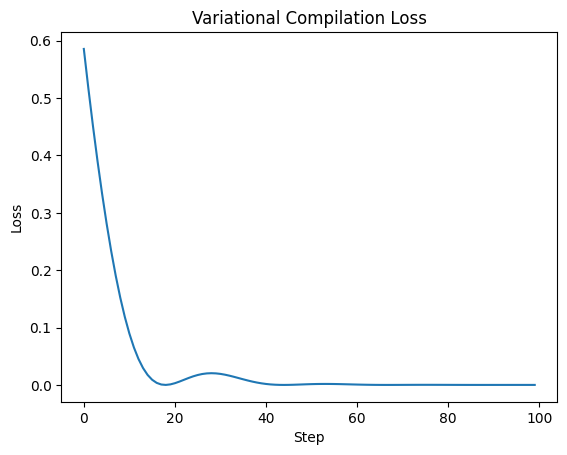


Final optimized parameters:
[[0.        1.5635816 0.       ]
 [0.        0.        0.       ]]


In [10]:
# Plot the loss history
plt.plot(loss_history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Variational Compilation Loss')
plt.show()

# Final parameters
print("\nFinal optimized parameters:")
print(params)

## Inspect the final state

After training, let’s see how close we got:

In [11]:
final_state = circuit(params)
print("Final state:", final_state)
print("Target state:", target_state)

Final state: [0.70965296+0.j 0.        +0.j 0.        +0.j 0.7045514 +0.j]
Target state: [0.70710677 0.         0.         0.70710677]


We used PennyLane with JAX and Optax to optimize a quantum circuit to produce a desired quantum state.